In [4]:
import copernicusmarine
from datetime import date, timedelta

/home/garrett/spack/opt/spack/linux-pop22-skylake/gcc-11.3.0/anaconda3-2022.10-p5cu5vz2jstyt2fk24irpty4jx45uqko/envs/fsu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# You only need to do this once.
# This will write credentials file at ~/.copernicusmarine/.copernicusmarine-credentials.
# You should be prompted to enter your username and password.

# copernicusmarine.login()

In [ ]:
dataset_id = "cmems_mod_glo_phy_my_0.083deg_P1D-m"

start_date = "2003-01-01"
end_date = "2003-01-01"

min_long = -90
max_long = 0

min_lat = 12
max_lat = 60

min_depth = 0
max_depth = 1
# max depth is 5727.9169921875
# If you are just testing that you can pull/plot data, set max_depth to 1 or some small value.

single_file = False  # Set to True to save as single NetCDF file

In [7]:
# To save each day as individual netCDF file:
def iterate_dates(start_date_str, end_date_str, date_format="%Y-%m-%d"):
    start_date = date.fromisoformat(start_date_str)
    end_date = date.fromisoformat(end_date_str)

    current_date = start_date
    while current_date <= end_date:
        yield current_date.strftime(date_format)
        current_date += timedelta(days=1)


if not single_file:
    for date_str in iterate_dates(start_date, end_date):
        copernicusmarine.subset(
            dataset_id=dataset_id,
            variables=[
                "thetao",  # Sea water potential temperature
                "so",  # Sea water salinity
                "uo",  # Eastward ocean current velocity
                "vo",  # Northward sea water velocity
                "zos",  # Sea Surface Height above Geoid
                "mlotst",  # Mixed Layer Thickness
            ],
            minimum_longitude=min_long,
            maximum_longitude=max_long,
            minimum_latitude=min_lat,
            maximum_latitude=max_lat,
            start_datetime=date_str,
            end_datetime=date_str,
            minimum_depth=min_depth,
            maximum_depth=max_depth,
            output_filename=f"{date_str}.nc",
            output_directory="data",
        )

INFO - 2025-06-27T15:04:40Z - Selected dataset version: "202311"
INFO - 2025-06-27T15:04:40Z - Selected dataset part: "default"
WARNING - 2025-06-27T15:04:43Z - Some of your subset selection [0, 6000] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-06-27T15:04:45Z - Starting download. Please wait...
100%|██████████| 18/18 [08:50<00:00, 29.46s/it]
INFO - 2025-06-27T15:13:36Z - Successfully downloaded to data/2003-01-01_(1).nc


In [8]:
# To save entire dataset as a single netCDF file:
# Warning: This file will likely be huge and take forever to download, depending on the lat/long/date ranges.
#          You should probably just save them as daily files.
if single_file:
    copernicusmarine.subset(
        dataset_id=dataset_id,
        variables=[
            "thetao",  # Sea water potential temperature
            "so",  # Sea water salinity
            "uo",  # Eastward ocean current velocity
            "vo",  # Northward sea water velocity
            "zos",  # Sea Surface Height above Geoid
            "mlotst",  # Mixed Layer Thickness
        ],
        minimum_longitude=min_long,
        maximum_longitude=max_long,
        minimum_latitude=min_lat,
        maximum_latitude=max_lat,
        start_datetime=start_date,
        end_datetime=end_date,
        minimum_depth=min_depth,
        maximum_depth=max_depth,
        output_filename=f"{start_date}_to_{end_date}.nc",
        output_directory="data",
    )

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

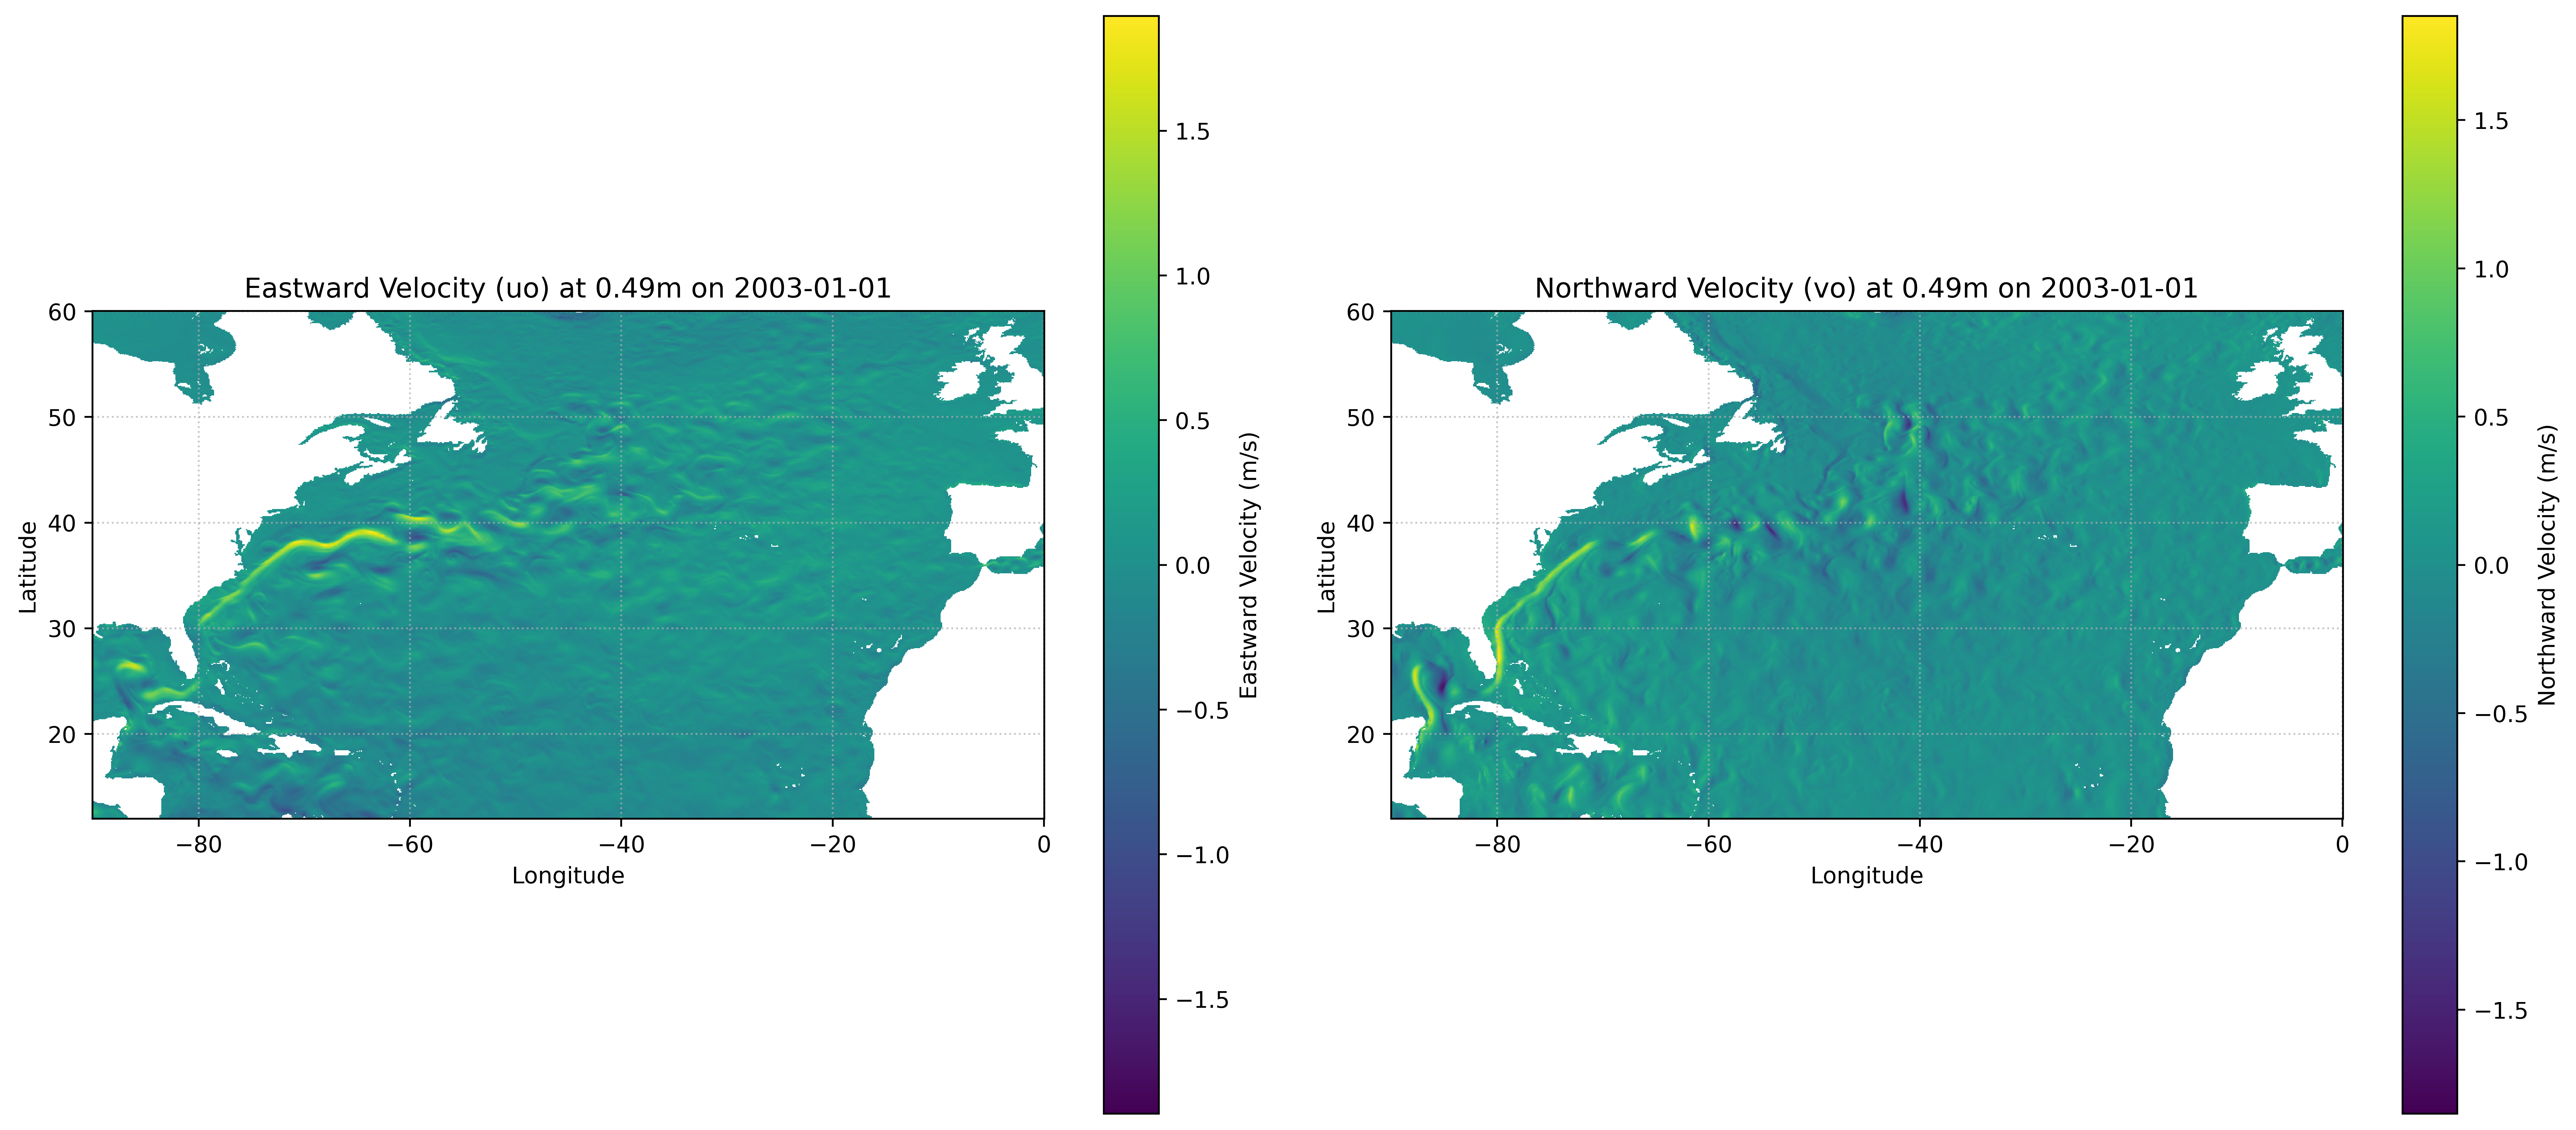

In [10]:
# Surface Velocity Maps at Start Date

# Eastward and Northward Velocity plots

colormap = "viridis"

ds = xr.open_dataset(f"data/{start_date}.nc")

times = [ds.time[0]]  # first time step
latitudes = ds.latitude  # get all latitudes
longitudes = ds.longitude  # get all longitudes
depths = ds.depth  # get all depths

# Select the first time step and the shallowest depth (surface)
time_step = ds.time[0]
surface_depth = ds.depth[0]

# Extract uo and vo at the specified time and depth
uo_surface = ds["uo"].sel(time=time_step, depth=surface_depth, method="nearest")
vo_surface = ds["vo"].sel(time=time_step, depth=surface_depth, method="nearest")

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.set_dpi(512)
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

# Plot UO (Eastward Velocity)
uo_surface.plot(
    ax=axes[0], cmap=colormap, cbar_kwargs={"label": "Eastward Velocity (m/s)"}
)
axes[0].set_title(
    f'Eastward Velocity (uo) at {surface_depth.item():.2f}m on {time_step.dt.strftime("%Y-%m-%d").item()}'
)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(True, linestyle=":", alpha=0.7)

# Plot VO (Northward Velocity)
vo_surface.plot(
    ax=axes[1], cmap=colormap, cbar_kwargs={"label": "Northward Velocity (m/s)"}
)
axes[1].set_title(
    f'Northward Velocity (vo) at {surface_depth.item():.2f}m on {time_step.dt.strftime("%Y-%m-%d").item()}'
)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(True, linestyle=":", alpha=0.7)

plt.tight_layout()

filename = (
    f"{time_step.dt.strftime('%Y-%m-%d').item()}_{surface_depth.item():.2f}_uo_vo"
)

plt.savefig(f"plots/png/{filename}.png")
# plt.savefig(f"plots/svg/{filename}.svg")

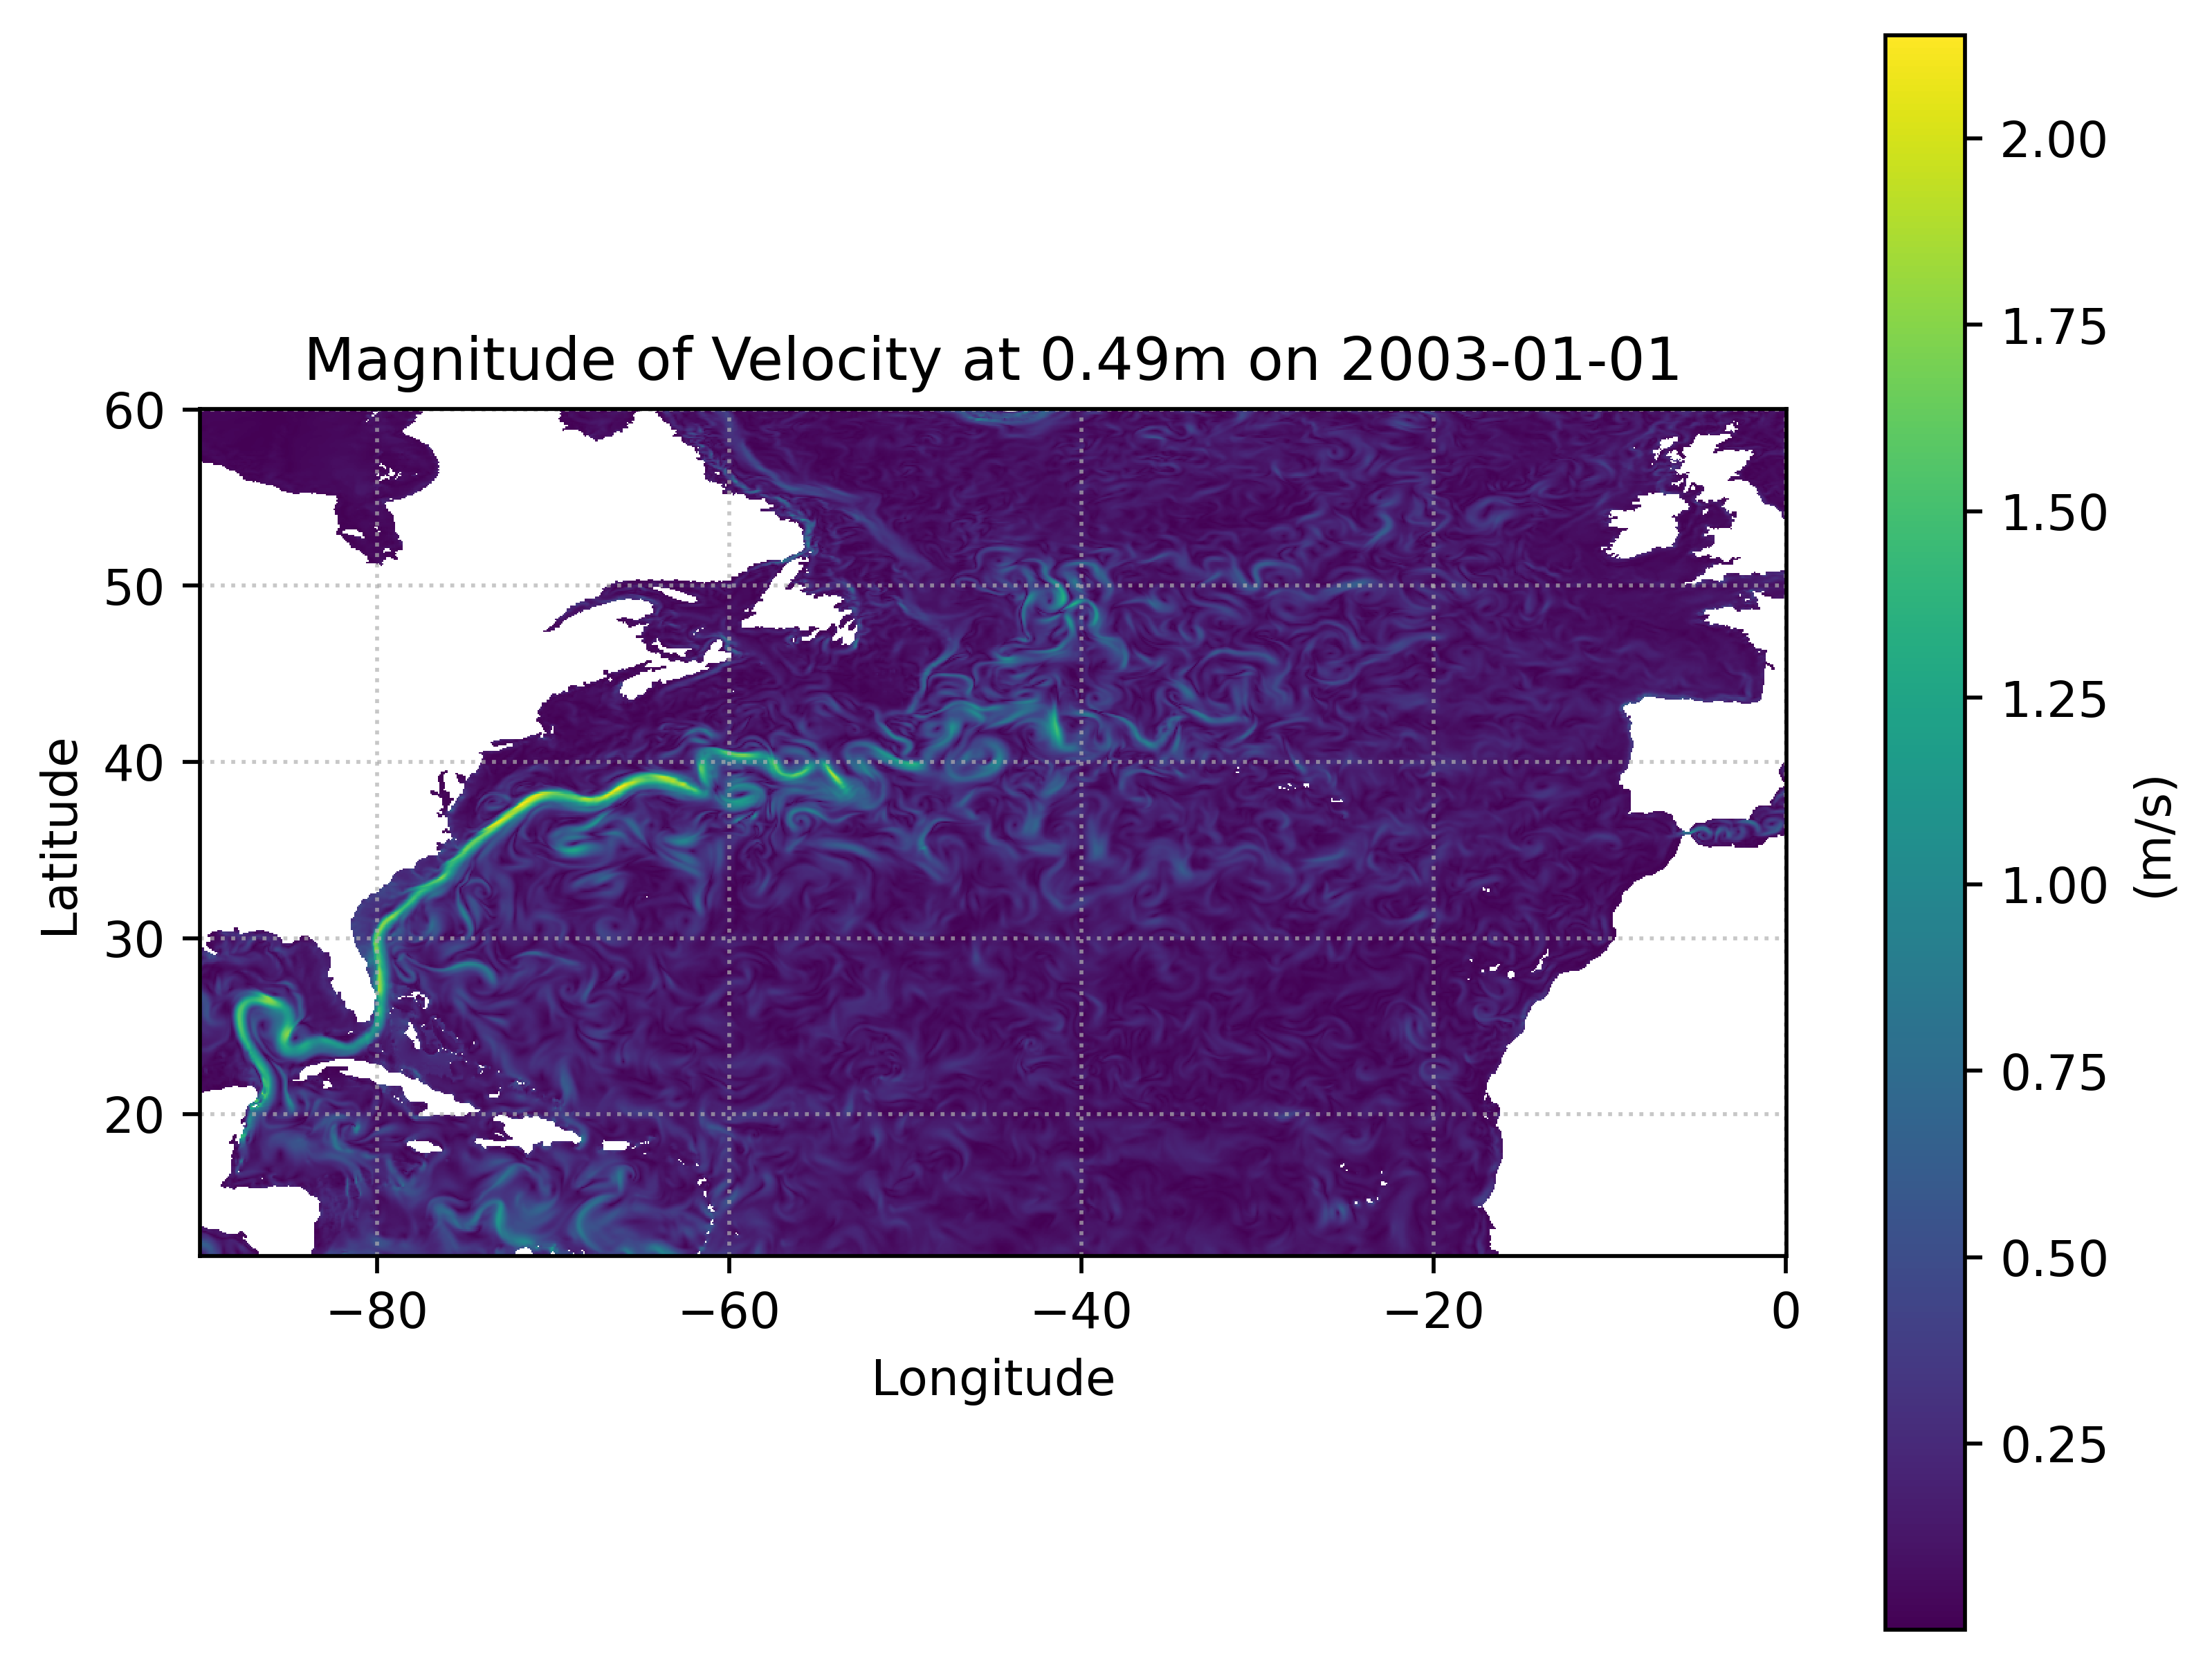

In [12]:
# Magnitude plot
magnitude = np.sqrt(uo_surface**2 + vo_surface**2)

fig, ax = plt.subplots()
fig.set(dpi=512)
ax.set_aspect("equal")
magnitude.plot(ax=ax, cmap=colormap, cbar_kwargs={"label": "(m/s)"})
ax.set_title(
    f'Magnitude of Velocity at {surface_depth.item():.2f}m on {time_step.dt.strftime("%Y-%m-%d").item()}'
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle=":", alpha=0.7)

plt.tight_layout()
plt.show()